In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install numpy scikit-learn
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting
!pip install opencv-python
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=be41e5e9d7a5aa590761a10ea22db55ff708daa250ba3205a2120bd7b51844c4
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
# Load CN features
cn_fa_feature_path = "histogram_features_all_subjects"
cn_features_dict = np.load(cn_fa_feature_path, allow_pickle=True).item()
cn_features = np.array(list(cn_features_dict.values()))

# Load AD features
ad_fa_feature_path = "histogram_features_all_subjects"
ad_features_dict = np.load(ad_fa_feature_path, allow_pickle=True).item()
ad_features = np.array(list(ad_features_dict.values()))

In [ ]:
# Labels
cn_labels = np.zeros(cn_features.shape[0])
ad_labels = np.ones(ad_features.shape[0])  # AD = 1

# Combine and scale
X = np.vstack((cn_features, ad_features))
y = np.hstack((cn_labels, ad_labels))
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)

assert torch.all((y_tensor == 0) | (y_tensor == 1)), "Labels should only contain 0 (CN) and 1 (AD)."

In [ ]:
# Graph structure (fully connected for simplicity)
num_nodes = X.shape[0]
edge_index = torch.combinations(torch.arange(num_nodes), r=2).T

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)
edge_index = edge_index.to(device)

Using device: cuda


In [ ]:
# GCN model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
# 20 iterations, 10% training
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)
num_epochs = 2500
accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []

In [ ]:
all_y_true = []
all_y_proba = []
all_fpr = []
all_tpr = []
all_auc = []
for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    # Create and move masks to device
    train_mask = torch.tensor(train_idx).to(device)
    test_mask = torch.tensor(test_idx).to(device)

    # Print class counts
    cn_train = np.sum(y[train_idx] == 0)
    ad_train = np.sum(y[train_idx] == 1)
    cn_test = np.sum(y[test_idx] == 0)
    ad_test = np.sum(y[test_idx] == 1)

    print(f"Training samples (CN): {cn_train}, (AD): {ad_train}")
    print(f"Testing samples (CN): {cn_test}, (AD): {ad_test}")

    # Initialize model
    model = GCN(input_dim=X.shape[1], hidden_dim=32, output_dim=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X_tensor, edge_index)
        loss = loss_fn(out[train_mask], y_tensor[train_mask])

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN or Inf loss detected at epoch {epoch}, stopping training.")
            break

        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        logits = model(X_tensor, edge_index)
        y_pred = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()

    y_true_test = y_tensor[test_mask].cpu().numpy()

    accuracy = accuracy_score(y_true_test, y_pred[test_mask.cpu().numpy()])
    precision = precision_score(y_true_test, y_pred[test_mask.cpu().numpy()])
    recall = recall_score(y_true_test, y_pred[test_mask.cpu().numpy()])
    f1 = f1_score(y_true_test, y_pred[test_mask.cpu().numpy()])
    cross_entropy_loss = log_loss(y_true_test, y_pred_proba[test_mask.cpu().numpy()])

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    losses.append(cross_entropy_loss)
    all_y_true.extend(y_true_test)
    all_y_proba.extend(y_pred_proba[test_mask.cpu().numpy(), 1])
    fpr, tpr, _ = roc_curve(y_true_test, y_pred_proba[test_mask.cpu().numpy(), 1])
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc(fpr, tpr))

    print(f"\nFold {fold + 1} Evaluation: ")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Cross-Entropy Loss: {cross_entropy_loss:.4f}")
    print("-" * 50)

# Average results
print("\nAverage Results across 20 folds:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average Precision: {np.mean(precisions):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average Cross-Entropy Loss: {np.mean(losses):.4f}")


Training fold 1
Training samples (CN): 13, (AD): 9
Testing samples (CN): 120, (AD): 79

Fold 1 Evaluation: 
Accuracy: 0.9950
Precision: 1.0000
Recall: 0.9873
F1 Score: 0.9936
Cross-Entropy Loss: 0.0251
--------------------------------------------------

Training fold 2
Training samples (CN): 13, (AD): 9
Testing samples (CN): 120, (AD): 79

Fold 2 Evaluation: 
Accuracy: 0.9548
Precision: 1.0000
Recall: 0.8861
F1 Score: 0.9396
Cross-Entropy Loss: 0.0856
--------------------------------------------------

Training fold 3
Training samples (CN): 13, (AD): 9
Testing samples (CN): 120, (AD): 79

Fold 3 Evaluation: 
Accuracy: 0.9950
Precision: 0.9875
Recall: 1.0000
F1 Score: 0.9937
Cross-Entropy Loss: 0.0283
--------------------------------------------------

Training fold 4
Training samples (CN): 13, (AD): 9
Testing samples (CN): 120, (AD): 79

Fold 4 Evaluation: 
Accuracy: 0.9598
Precision: 1.0000
Recall: 0.8987
F1 Score: 0.9467
Cross-Entropy Loss: 0.0782
-----------------------------------

## Top features per fold


Training fold 1
Fold 1 completed.

Training fold 2
Fold 2 completed.

Training fold 3
Fold 3 completed.

Training fold 4
Fold 4 completed.

Training fold 5
Fold 5 completed.

Training fold 6
Fold 6 completed.

Training fold 7
Fold 7 completed.

Training fold 8
Fold 8 completed.

Training fold 9
Fold 9 completed.

Training fold 10
Fold 10 completed.

Training fold 11
Fold 11 completed.

Training fold 12
Fold 12 completed.

Training fold 13
Fold 13 completed.

Training fold 14
Fold 14 completed.

Training fold 15
Fold 15 completed.

Training fold 16
Fold 16 completed.

Training fold 17
Fold 17 completed.

Training fold 18
Fold 18 completed.

Training fold 19
Fold 19 completed.

Training fold 20
Fold 20 completed.

Top 10 important features across all folds:
1. Feature f177 - Mean: 0.0545, Std: 0.0302
2. Feature f83 - Mean: 0.0420, Std: 0.0156
3. Feature f178 - Mean: 0.0405, Std: 0.0474
4. Feature f11 - Mean: 0.0399, Std: 0.0167
5. Feature f53 - Mean: 0.0386, Std: 0.0148
6. Feature f26 -

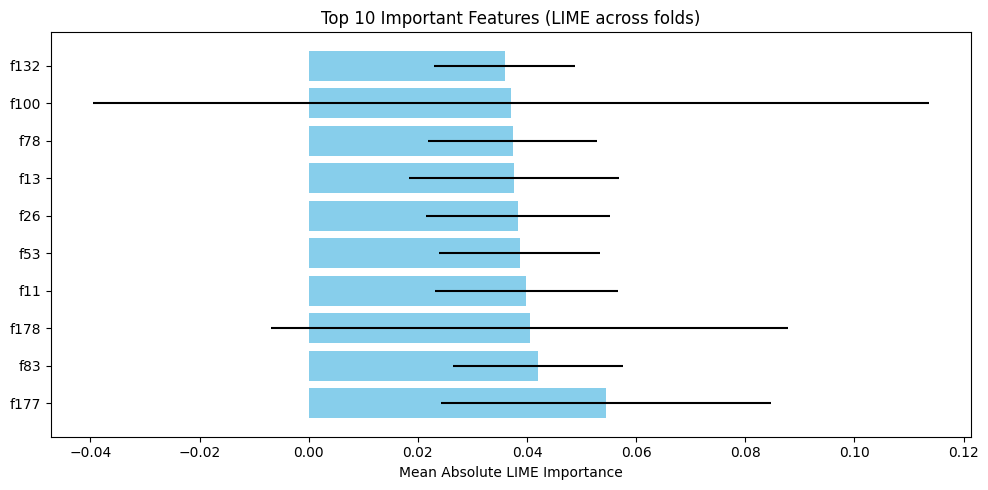

In [ ]:
num_test_samples = 20  # LIME explanations per fold
top_n = 10  # top-N features to report

feature_names = [f"f{i}" for i in range(X.shape[1])]
global_feature_scores = []  # to store importance vectors per fold

for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    train_mask = torch.tensor(train_idx).to(device)
    test_mask = torch.tensor(test_idx).to(device)

    model = GCN(input_dim=X.shape[1], hidden_dim=32, output_dim=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X_tensor, edge_index)
        loss = loss_fn(out[train_mask], y_tensor[train_mask])
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN/Inf loss at epoch {epoch}, stopping.")
            break
        loss.backward()
        optimizer.step()

    # Define prediction function for LIME
    def predict_fn(input_np):
        input_tensor = torch.tensor(input_np, dtype=torch.float).to(device)
        model.eval()
        with torch.no_grad():
            logits = model(input_tensor, edge_index)
            proba = F.softmax(logits, dim=1).cpu().numpy()
        return proba

    # Setup LIME explainer
    explainer = LimeTabularExplainer(
        training_data=X[train_idx],
        feature_names=feature_names,
        class_names=["CN", "MCI"],
        mode="classification"
    )

    # Store feature importances per fold
    fold_feature_scores = np.zeros(X.shape[1])

    for i in range(min(num_test_samples, len(test_idx))):
        test_sample = X[test_idx[i]].reshape(1, -1)
        explanation = explainer.explain_instance(
            test_sample[0], predict_fn, num_features=X.shape[1]
        )
        for feature_idx, importance in explanation.as_map()[1]:
            fold_feature_scores[feature_idx] += abs(importance)

    fold_feature_scores /= num_test_samples
    global_feature_scores.append(fold_feature_scores)

    print(f"Fold {fold + 1} completed.")


global_feature_scores = np.array(global_feature_scores)


mean_importance = np.mean(global_feature_scores, axis=0)
std_importance = np.std(global_feature_scores, axis=0)


top_indices = np.argsort(mean_importance)[::-1][:top_n]

print(f"\nTop {top_n} important features across all folds:")
for rank, idx in enumerate(top_indices, 1):
    print(f"{rank}. Feature {feature_names[idx]} - Mean: {mean_importance[idx]:.4f}, Std: {std_importance[idx]:.4f}")


plt.figure(figsize=(10, 5))
plt.barh([feature_names[i] for i in top_indices[::-1]],
         mean_importance[top_indices][::-1],
         xerr=std_importance[top_indices][::-1],
         color='skyblue')
plt.xlabel("Mean Absolute LIME Importance")
plt.title(f"Top {top_n} Important Features (LIME across folds)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


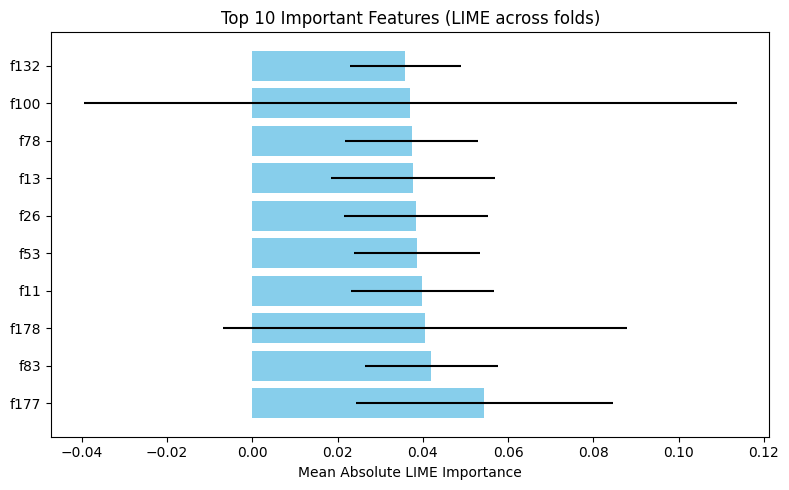

In [ ]:
plt.figure(figsize=(8, 5))
plt.barh([feature_names[i] for i in top_indices[::-1]],
         mean_importance[top_indices][::-1],
         xerr=std_importance[top_indices][::-1],
         color='skyblue')
plt.xlabel("Mean Absolute LIME Importance")
plt.title(f"Top {top_n} Important Features (LIME across folds)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


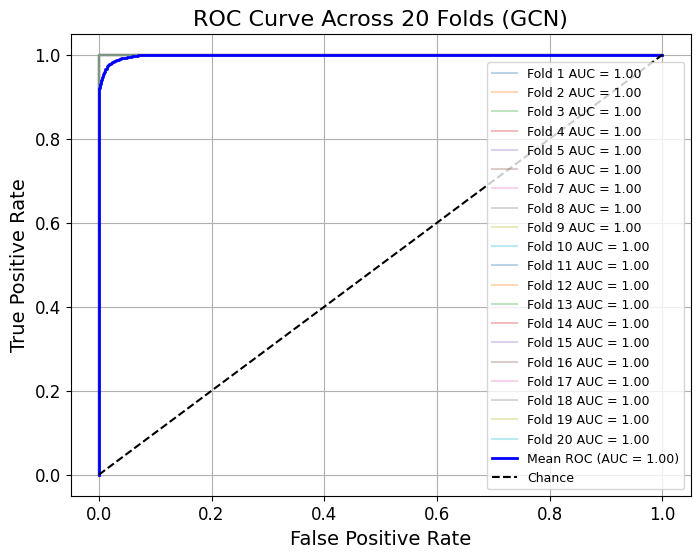

In [ ]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

# Average ROC Curve
fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Across 20 Folds (GCN)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)

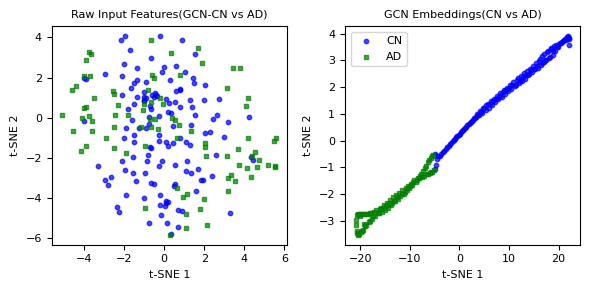

In [ ]:
X_input = X_tensor.cpu().numpy()
tsne_input = TSNE(n_components=2, init='pca', random_state=42)
input_2d = tsne_input.fit_transform(X_input)


model.eval()
with torch.no_grad():
    x = model.conv1(X_tensor, edge_index)
    x = F.relu(x)
    embeddings = model.conv2(x, edge_index)
    embeddings = F.relu(embeddings).cpu().numpy()

tsne_embed = TSNE(n_components=2, init='pca', random_state=42)
embed_2d = tsne_embed.fit_transform(embeddings)


labels = y_tensor.cpu().numpy()


colors = ['blue', 'green']
markers = ['o', 's']
class_names = ['CN', 'AD']
font_size = 8

fig, axes = plt.subplots(1, 2, figsize=(6, 3))


for cls, color, marker in zip([0, 1], colors, markers):
    idx = labels == cls
    axes[0].scatter(input_2d[idx, 0], input_2d[idx, 1],
                    c=color, marker=marker, label=class_names[cls], alpha=0.7, s=10)
axes[0].set_title("Raw Input Features(GCN-CN vs AD)", fontsize=font_size)
axes[0].set_xlabel("t-SNE 1", fontsize=font_size)
axes[0].set_ylabel("t-SNE 2", fontsize=font_size)
axes[0].tick_params(labelsize=font_size)


for cls, color, marker in zip([0, 1], colors, markers):
    idx = labels == cls
    axes[1].scatter(embed_2d[idx, 0], embed_2d[idx, 1],
                    c=color, marker=marker, label=class_names[cls], alpha=0.7, s=10)
axes[1].set_title("GCN Embeddings(CN vs AD)", fontsize=font_size)
axes[1].set_xlabel("t-SNE 1", fontsize=font_size)
axes[1].set_ylabel("t-SNE 2", fontsize=font_size)
axes[1].tick_params(labelsize=font_size)


axes[1].legend(fontsize=font_size, loc='best')

plt.tight_layout()
plt.savefig("tsne_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
